In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
#Reading the Training set
df_train = pd.read_csv('./training_autoinsurance.csv')
df_train.head()

,CustomerID,ShoppingPt,RecordType,Day,Time,State,Location,GroupSize,Homeowner,CarAge,...,PrevC,PrevDuration,A,B,C,D,E,F,G,Cost
0,10082007,2,0,4,16:42,OR,15195,2,0,7,...,2,6,1,1,2,3,1,1,2,603
1,10082007,3,0,4,16:43,OR,15195,2,0,7,...,2,6,1,1,2,3,1,1,2,603
2,10082007,4,1,1,18:20,OR,15195,2,0,7,...,2,6,1,0,2,3,0,1,2,626
3,10082012,1,0,4,12:39,PA,10862,1,1,15,...,1,2,0,0,1,1,0,0,1,582
4,10082012,2,0,4,12:39,PA,10862,1,1,15,...,1,2,0,0,1,1,0,0,2,589


In [4]:
#Creating TimeDeltas between each occurance
df_train['daytimeDelta'] = df_train['Day'].apply(str)
df_train['daytimeDelta'] = df_train['daytimeDelta'] + ' days ' + (df_train['Time'] + ':00').str.zfill(8)
df_train['daytimeDelta'] = df_train['daytimeDelta'].apply(pd.to_timedelta)
df_train[['daytimeDelta', 'RecordType', 'CustomerID']].head()

,daytimeDelta,RecordType,CustomerID
0,4 days 16:42:00,0,10082007
1,4 days 16:43:00,0,10082007
2,1 days 18:20:00,1,10082007
3,4 days 12:39:00,0,10082012
4,4 days 12:39:00,0,10082012


In [17]:
#Creating Interaction Times from TimeDeltas, Total TouchPoints and Total Timetosale for each group
groupbyCustomers = df_train.groupby(['CustomerID'])
df_groupGlobal = pd.DataFrame()

for name, group in groupbyCustomers:
    df_group = pd.DataFrame()
    #Creating Time Between Interactions from the Time Deltas
    s_interactiontime = (group['daytimeDelta'] - group['daytimeDelta'].shift()).abs()
    df_group = pd.concat([df_group, s_interactiontime], axis=0)    
    #Creating Total Touchpoints per customer
    totalTouchpoints = group['ShoppingPt'].max()
    df_group['Total Touchpoints'] = totalTouchpoints
    #Creating Total Timetosale per customer
    totalTimetosale = (group['daytimeDelta'] - group['daytimeDelta'].shift()).abs().sum()
    df_group['Total Timetosale'] = totalTimetosale  
    df_groupGlobal = pd.concat([df_groupGlobal, df_group], axis=0)

#Renaming first column to Time between Interactions 
df_groupGlobal.rename(columns={0: 'TimeBetweenInteractions'}, inplace=True)
#Concatenating the Interaction Times to the training dataframe
df_train = pd.concat([df_train, df_groupGlobal], axis=1)

In [18]:
#Converting Timedeltas to absolute seconds
df_train['TimeBetweenInteractions'] = df_train['TimeBetweenInteractions'].fillna(0)
df_train['TimeBetweenInteractions'] = df_train['TimeBetweenInteractions'].apply(lambda x: x / np.timedelta64(1, 's'))
df_train['Total Timetosale'] = df_train['Total Timetosale'].fillna(0)
df_train['Total Timetosale'] = df_train['Total Timetosale'].apply(lambda x: x / np.timedelta64(1, 's'))

In [19]:
df_train[['daytimeDelta', 'TimeBetweenInteractions', 'RecordType',
          'Total Touchpoints', 'Total Timetosale', 'CustomerID']].head(21)

,daytimeDelta,TimeBetweenInteractions,RecordType,Total Touchpoints,Total Timetosale,CustomerID
0,4 days 16:42:00,0,0,4,506700,10082007
1,4 days 16:43:00,60,0,4,506700,10082007
2,1 days 18:20:00,253380,1,4,506700,10082007
3,4 days 12:39:00,0,0,5,247380,10082012
4,4 days 12:39:00,0,0,5,247380,10082012
5,4 days 12:40:00,60,0,5,247380,10082012
6,4 days 12:41:00,60,0,5,247380,10082012
7,1 days 16:00:00,247260,1,5,247380,10082012
8,0 days 09:40:00,0,0,5,88260,10082013
9,0 days 09:41:00,60,0,5,88260,10082013


# Exploratory Data Analysis

###Regional Metrics: States / Zip codes

a.	What region/states contribute to largest customer inflow?
<LI>i. Unique Customers and Unique Zip Code Locations per state.
<LI>ii.	No. Customers per zip code: This should give us the density of customer traffic.

In [6]:
s_customers = df_train.groupby(['State'])['CustomerID'].nunique().order(ascending=False)
s_zipcode = df_train.groupby(['State'])['Location'].nunique().order(ascending=False)

In [7]:
df_result = pd.concat([s_customers, s_zipcode], axis=1)
df_result['Customers/Location'] = df_result['CustomerID']/df_result['Location']
df_result['Customers/Location'] = df_result['Customers/Location'].apply(lambda x: round(x,2))
df_result = df_result.sort('Customers/Location', ascending=False)
print df_result.tail()

    CustomerID  Location  Customers/Location
KS         469        86                5.45
WY          89        20                4.45
WV         417        96                4.34
DC         294        84                3.50
GA         675       305                2.21


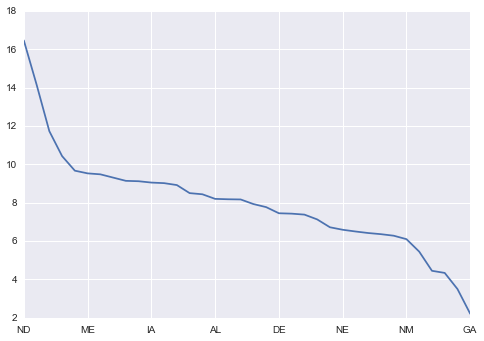

In [8]:
df_result['Customers/Location'].plot()

In [9]:
print df_result[df_result['CustomerID'] >= df_result['CustomerID'].mean()].head(10)

    CustomerID  Location  Customers/Location
CT        1549       132               11.73
FL        7789       747               10.43
IN        2078       215                9.67
PA        4823       509                9.48
CO        1911       209                9.14
OH        3531       387                9.12
AL        1918       234                8.20
NY        7250       886                8.18
MD        2274       306                7.43
WA        1932       301                6.42


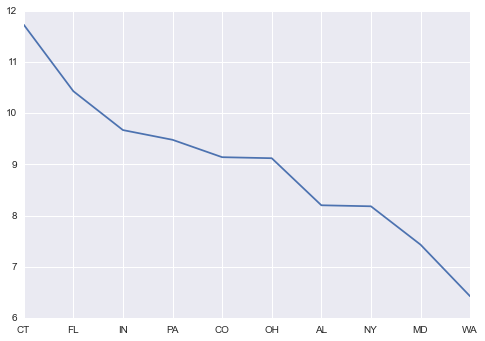

In [10]:
df_result[df_result['CustomerID'] >= df_result['CustomerID'].mean()]['Customers/Location'].plot()

b. What is the mean quoted price per customer?
<LI>i. What is the mean purchased price? Any trends amidst the states.

In [11]:
s_quotedCost = df_train[df_train['RecordType'] == 0].groupby(['State'])['Cost'].mean().order(ascending=False)
s_purchasedCost = df_train[df_train['RecordType'] == 1].groupby(['State'])['Cost'].mean().order(ascending=False)

In [12]:
df_result = pd.concat([s_quotedCost, s_purchasedCost], axis=1)
df_result.columns = ['quotedCost', 'purchaseCost']
df_result['Sensitivity'] = (df_result['purchaseCost'] - df_result['quotedCost'])/df_result['purchaseCost'] * 100
df_result['Sensitivity'] = df_result['Sensitivity'].apply(lambda x: round(x,2))
df_result = df_result.sort('Sensitivity', ascending=True)
print df_result.head(5)

    quotedCost  purchaseCost  Sensitivity
ND  633.003390    621.967290        -1.77
CT  649.232135    640.847644        -1.31
PA  641.465143    637.638399        -0.60
CO  628.398975    624.706960        -0.59
NH  621.918926    618.323481        -0.58


In [13]:
print df_result[df_result['Sensitivity'] > 0].head(5)

    quotedCost  purchaseCost  Sensitivity
AR  632.726255    632.808717         0.01
WA  634.922316    635.073499         0.02
KY  645.591091    645.883268         0.05
NV  652.078423    653.391808         0.20
DC  656.704289    658.238095         0.23


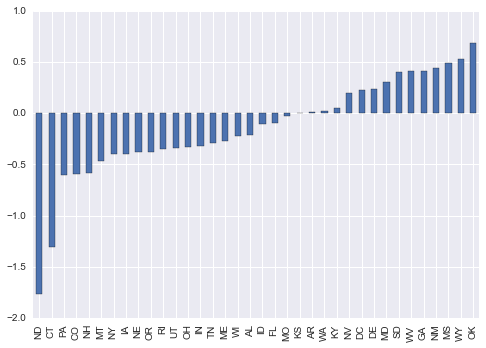

In [14]:
df_result['Sensitivity'].plot(kind='bar')

###People Persona Metrics

a. Average group size<br>
b. Average Oldest / Oldest Age<br>
c. Married<br>
d. Home Ownership<br>
e. Average Car age<br>
f. Car value<br>
g. Time Between Interactions

In [20]:
df_purchase = df_train[df_train['RecordType'] == 1]
s_group = df_purchase.groupby(['State'])['GroupSize'].mean().order(ascending=False)
s_oldest = df_purchase.groupby(['State'])['AgeOldest'].mean().order(ascending=False)
s_youngest = df_purchase.groupby(['State'])['AgeYoungest'].mean().order(ascending=False)
s_carAge = df_purchase.groupby(['State'])['CarAge'].mean().order(ascending=False)
s_riskFactor = df_purchase.groupby(['State'])['RiskFactor'].mean().order(ascending=False)

In [21]:
s_married = df_purchase[df_purchase['Married'] ==1].groupby(['State'])['CustomerID'].nunique().order(ascending=False)
s_married.name = 'Married'
s_unmarried = df_purchase[df_purchase['Married'] ==0].groupby(['State'])['CustomerID'].nunique().order(ascending=False)
s_unmarried.name = 'UnMarried'
s_homeowner = df_purchase[df_purchase['Homeowner'] ==1].groupby(['State'])['CustomerID'].nunique().order(ascending=False)
s_homeowner.name = 'Homeowners'
s_renter = df_purchase[df_purchase['Homeowner'] ==0].groupby(['State'])['CustomerID'].nunique().order(ascending=False)
s_renter.name = 'Renters'
s_nocustomers = df_purchase.groupby(['State'])['CustomerID'].nunique().order(ascending=False)
s_nocustomers.name = 'Total Customers'
s_timebtwninteractions = df_train.groupby(['State'])['TimeBetweenInteractions'].mean().order(ascending=False)
s_timebtwninteractions.name = 'Avg Interaction Span To Sale'
s_totaltouchpoints = df_train.groupby(['State'])['Total Touchpoints'].mean().order(ascending=False)
s_totaltouchpoints.name = 'Total Touchpoints To Sale'

In [22]:
df_result = pd.concat([s_group, s_oldest, s_youngest, s_carAge, 
                       s_riskFactor, s_married, s_unmarried, s_homeowner, 
                       s_renter, s_nocustomers, s_timebtwninteractions, s_totaltouchpoints], axis=1)
df_result['Married'] = (df_result['Married']/df_result['Total Customers']).round(decimals=4) * 100
df_result['UnMarried'] = (df_result['UnMarried']/df_result['Total Customers']).round(decimals=4) * 100
df_result['Homeowners'] = (df_result['Homeowners']/df_result['Total Customers']).round(decimals=4) * 100
df_result['Renters'] = (df_result['Renters']/df_result['Total Customers']).round(decimals=4) * 100
#Calculating Averge Interaction time to Sale in minutes
df_result['Avg Interaction Span To Sale'] = df_result['Avg Interaction Span To Sale']/60
df_result = df_result.sort('Avg Interaction Span To Sale', ascending=False)
df_result[df_result['Total Customers'] >= 1000].head(10)

,GroupSize,AgeOldest,AgeYoungest,CarAge,RiskFactor,Married,UnMarried,Homeowners,Renters,Total Customers,Avg Interaction Span To Sale,Total Touchpoints To Sale
NY,1.244690,47.542207,44.903448,7.013241,2.127448,24.59,75.41,58.23,41.77,7250,220.766680,7.299302
PA,1.216463,44.010574,41.381505,7.797429,3.058469,20.17,79.83,56.50,43.50,4823,217.184104,7.370590
WA,1.224120,43.289855,41.138716,8.626294,3.025257,21.53,78.47,47.46,52.54,1932,212.149012,7.677929
MO,1.212323,42.977519,40.450458,7.869276,3.157080,15.32,84.68,47.13,52.87,1201,209.660051,7.434467
CT,1.182699,43.198192,40.783731,8.921885,3.075908,16.59,83.41,37.19,62.81,1549,205.041443,7.422342
CO,1.206175,41.423862,39.577185,9.169545,3.111593,20.04,79.96,50.13,49.87,1911,204.962949,7.526125
OR,1.185848,43.209719,41.504689,9.864450,3.009288,17.90,82.10,41.52,58.48,1173,201.550431,7.409699
MD,1.185136,41.473615,39.159191,8.281882,2.744042,17.02,82.98,41.47,58.53,2274,199.919516,7.277869
OH,1.171623,42.483149,40.684792,8.710847,3.099537,15.01,84.99,53.75,46.25,3531,198.533537,7.259316
IN,1.166987,41.811357,39.597690,9.261790,2.839053,14.92,85.08,48.60,51.40,2078,193.499247,7.261169


In [23]:
df_result[df_result['Total Customers'] >= 1000].tail(10)

,GroupSize,AgeOldest,AgeYoungest,CarAge,RiskFactor,Married,UnMarried,Homeowners,Renters,Total Customers,Avg Interaction Span To Sale,Total Touchpoints To Sale
MD,1.185136,41.473615,39.159191,8.281882,2.744042,17.02,82.98,41.47,58.53,2274,199.919516,7.277869
OH,1.171623,42.483149,40.684792,8.710847,3.099537,15.01,84.99,53.75,46.25,3531,198.533537,7.259316
IN,1.166987,41.811357,39.597690,9.261790,2.839053,14.92,85.08,48.60,51.40,2078,193.499247,7.261169
AL,1.331595,45.893118,41.762252,9.137643,3.071429,23.41,76.59,70.96,29.04,1918,191.187247,7.132146
FL,1.303633,53.066761,50.404673,6.614456,1.980223,27.55,72.45,68.34,31.66,7789,188.338050,7.862378
UT,1.306394,37.989343,34.366785,9.710480,3.174737,23.00,77.00,43.43,56.57,1126,173.515023,7.691037
TN,1.223252,44.781740,42.430813,8.138374,3.083051,17.62,82.38,53.57,46.43,1402,170.424033,7.372832
KY,1.203891,42.720623,40.395331,9.171984,3.128889,17.35,82.65,41.40,58.60,1285,170.014496,7.360461
NV,1.297418,47.169190,43.561888,8.226180,2.984513,25.29,74.71,54.32,45.68,1123,154.565732,7.809268
OK,1.227397,42.029224,39.635616,8.484018,3.119363,20.09,79.91,51.60,48.40,1095,153.235318,7.438940


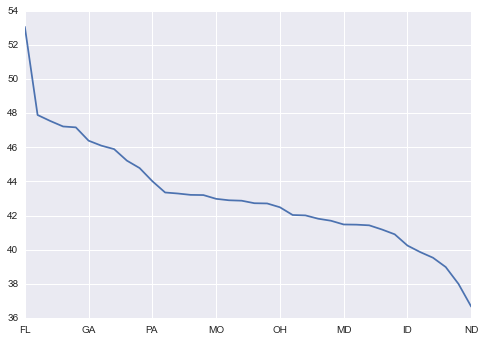

In [24]:
df_result.sort('AgeOldest', ascending=False).transpose().ix['AgeOldest'].plot()

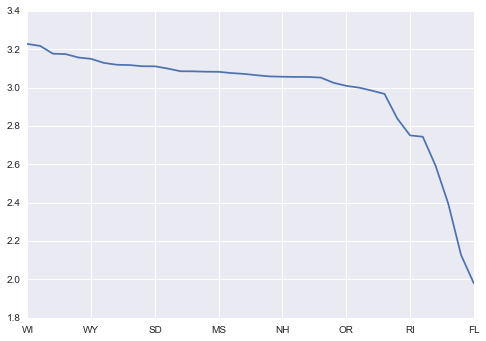

In [25]:
df_result.sort('RiskFactor', ascending=False).transpose().ix['RiskFactor'].plot()

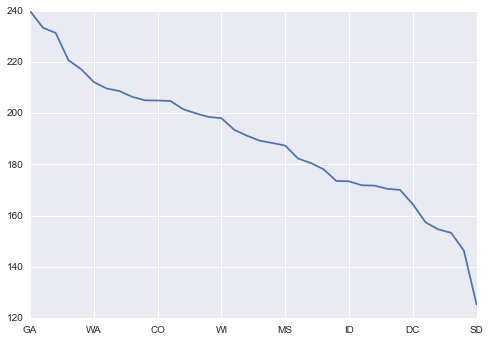

In [26]:
df_result.sort('Avg Interaction Span To Sale', ascending=False).transpose().ix['Avg Interaction Span To Sale'].plot()

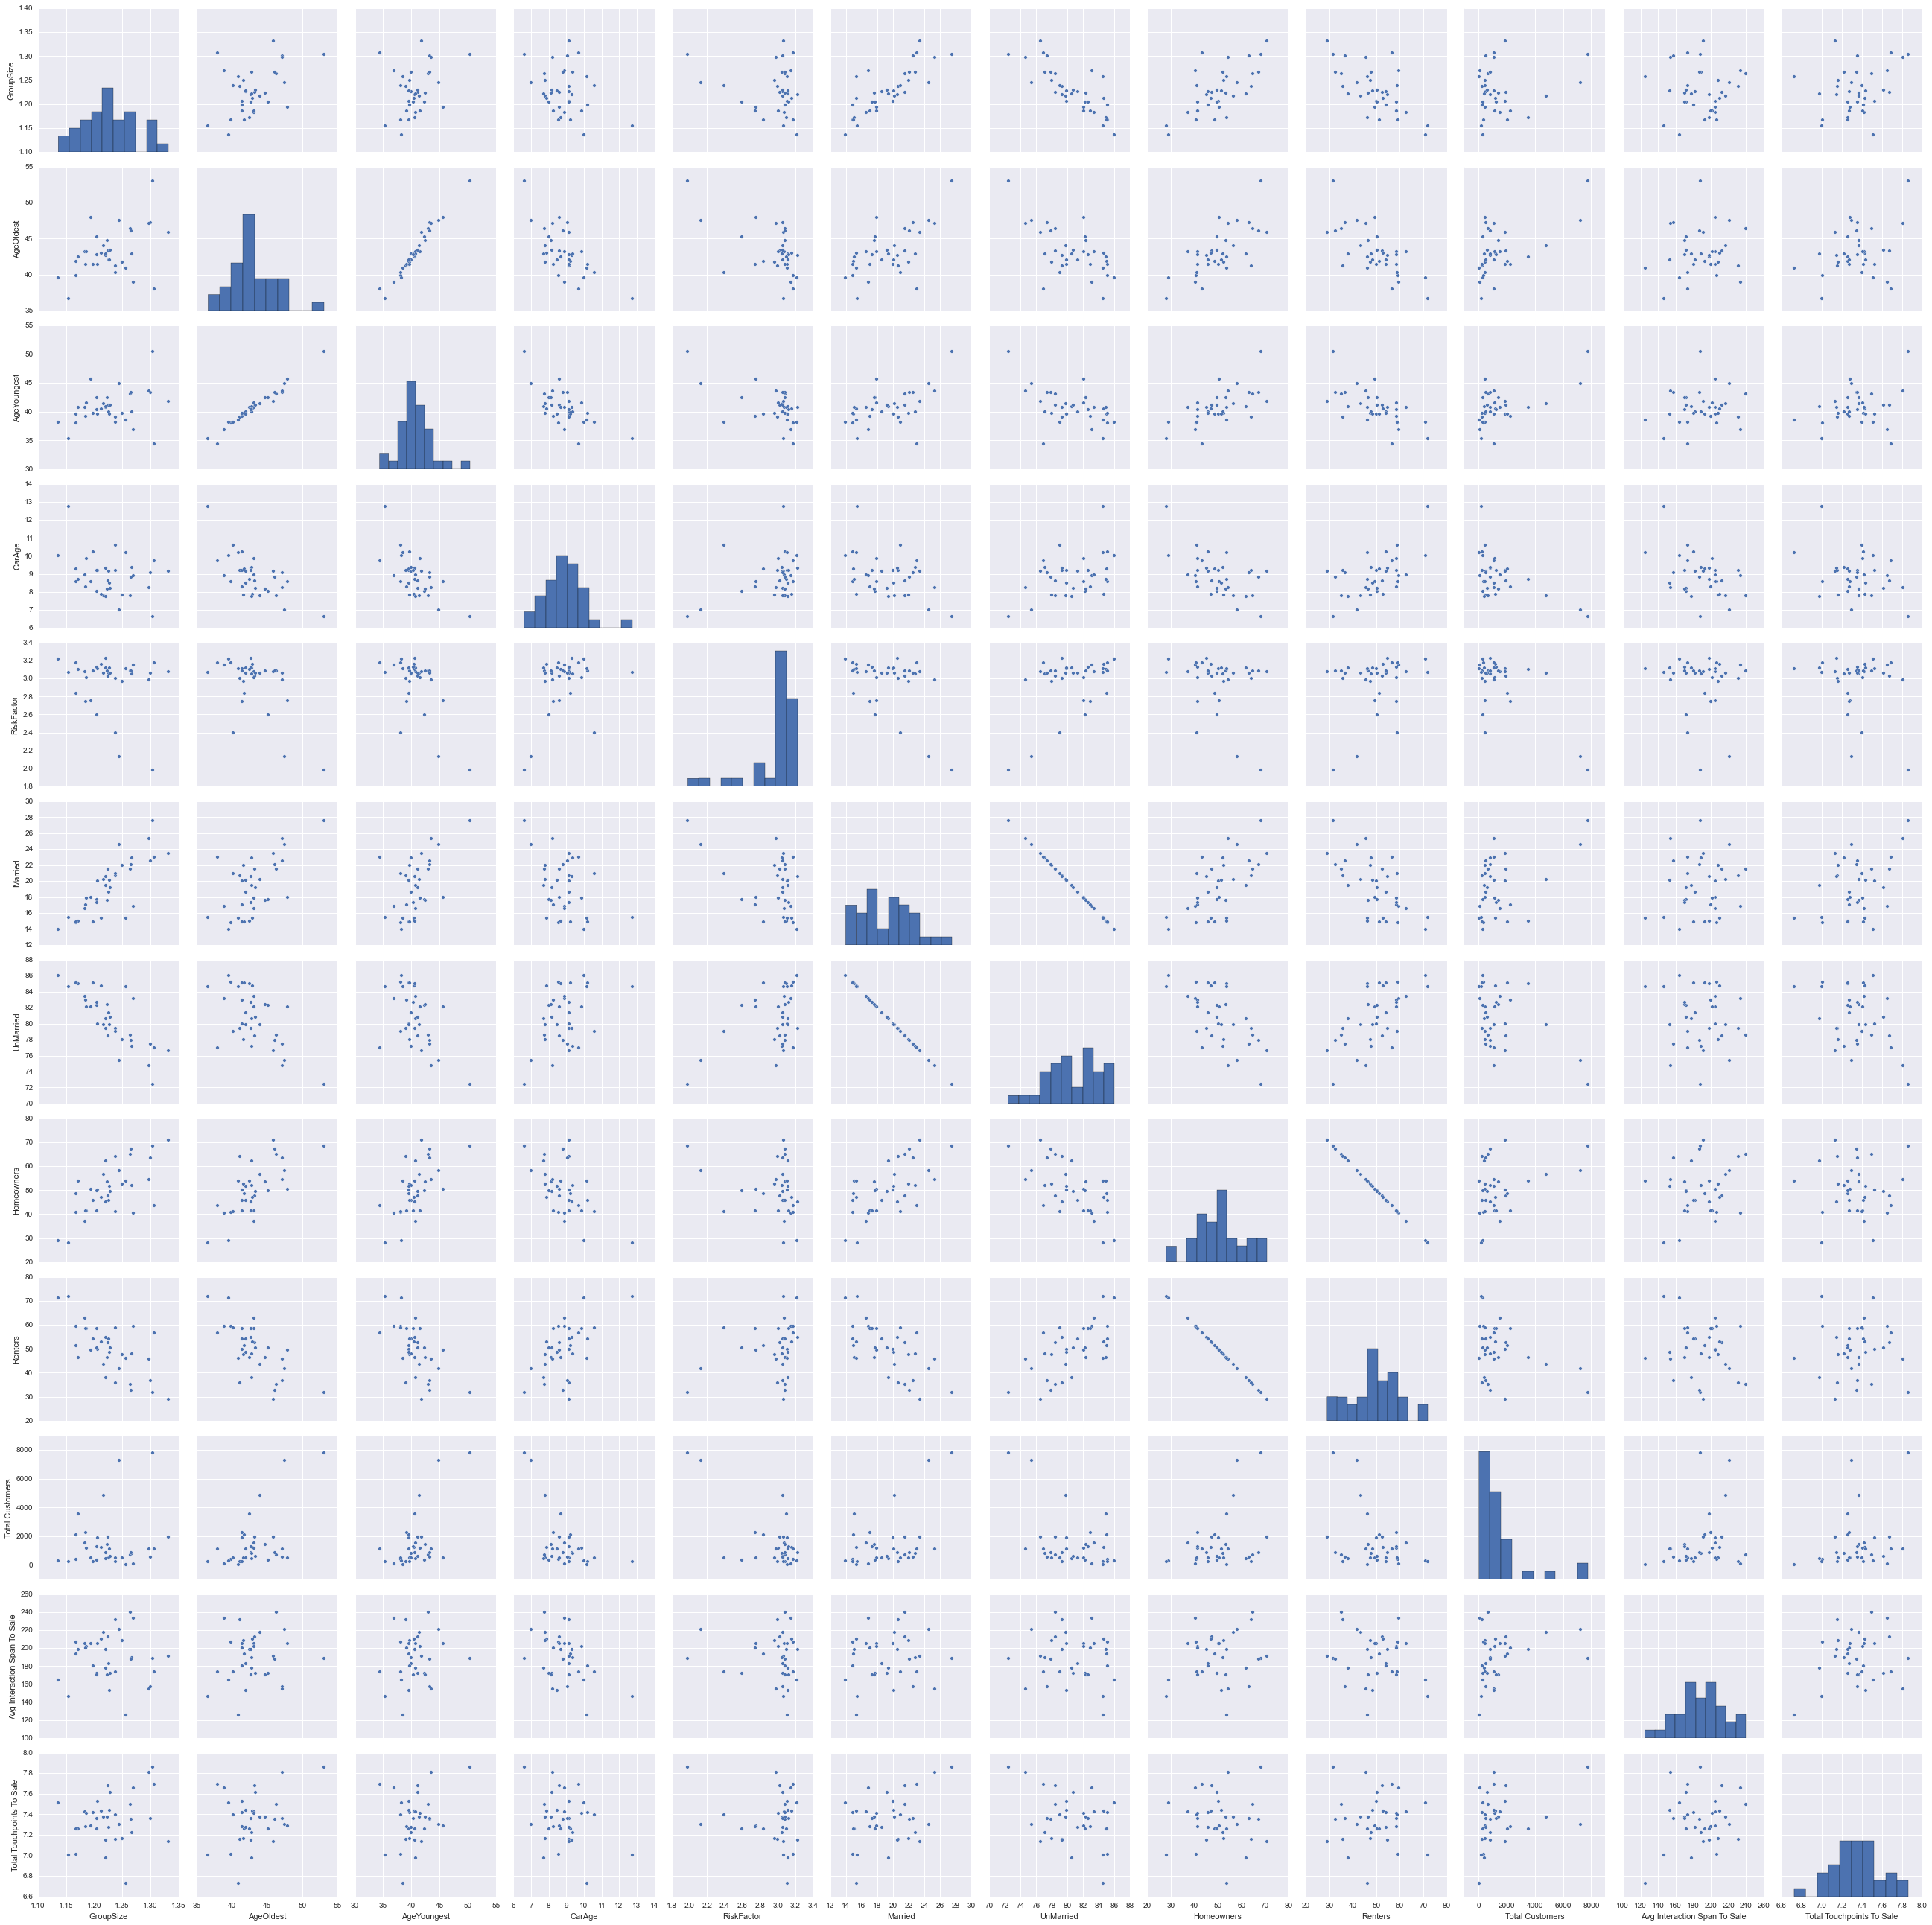

In [86]:
sns.pairplot(df_result)

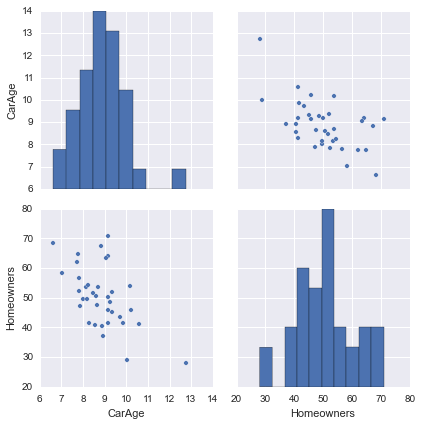

In [27]:
sns.pairplot(df_result[['CarAge','Homeowners']])

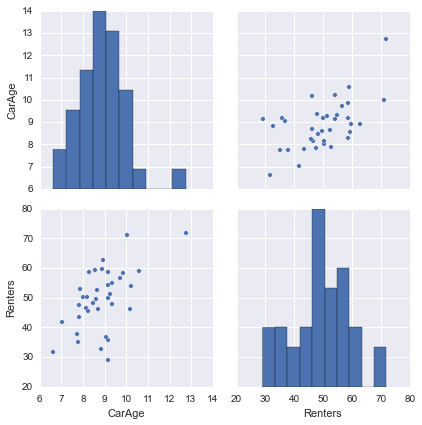

In [28]:
sns.pairplot(df_result[['CarAge','Renters']])

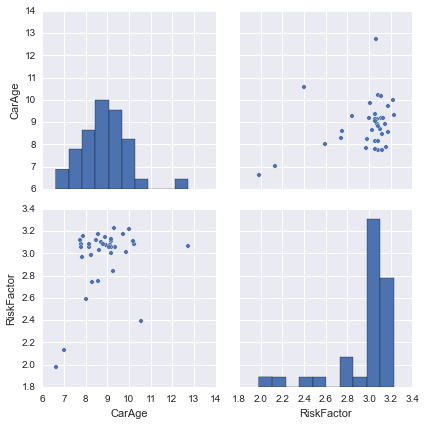

In [29]:
sns.pairplot(df_result[['CarAge','RiskFactor']])

###Product Metrics

In [41]:
#Select the Product options for the purchased records
df_prodOptions = df_train.ix[df_train['RecordType'] == 1,-12:-5]
totalCount = df_prodOptions.describe().T['count'][0]
df_prodOptions.head()

,A,B,C,D,E,F,G
2,1,0,2,3,0,1,2
7,0,0,1,2,0,0,2
12,1,0,3,3,0,2,1
20,1,0,3,3,0,1,2
24,1,0,3,3,0,0,4


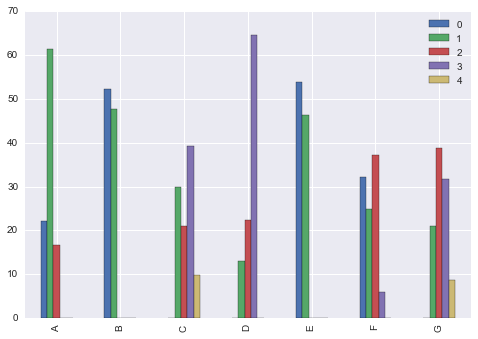

In [31]:
df_prodMetrics = pd.DataFrame()
for index in df_prodOptions.columns:
    s_valuecounts = (df_prodOptions[index].value_counts()/totalCount).round(decimals=4) * 100
    s_valuecounts.name = index
    df_prodMetrics = pd.concat([df_prodMetrics, s_valuecounts], axis=1)

df_prodMetrics = df_prodMetrics.fillna(0)
df_prodMetrics.T.plot(kind='bar')

# Classification Model

In [44]:
from sklearn.cross_validation import train_test_split,cross_val_score
from sklearn.preprocessing import scale
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

In [45]:
#Function to create dummy variables for categorical data types
def create_dummies(df):
    df.rename(columns=lambda x: x.strip())
    for colHeader in df.columns:
        #print colHeader
        col = df[colHeader]
        if (col.dtype == object):
            #Converting the Categorical variables to dummy/indicator variables 
            df = pd.concat([df, pd.get_dummies(df[colHeader], prefix=colHeader)], axis=1)
    return df

In [48]:
df_prodOptions = df_train[['A','B','C','D','E','F','G']]
df_train_model = df_train.drop(['CustomerID','ShoppingPt','Time','daytimeDelta','Location',
                                'A','B','C','D','E','F','G'], axis=1)
print df_train_model.columns
print df_prodOptions.columns

Index([u'RecordType', u'Day', u'State', u'GroupSize', u'Homeowner', u'CarAge', u'CarValue', u'RiskFactor', u'AgeOldest', u'AgeYoungest', u'Married', u'PrevC', u'PrevDuration', u'Cost', u'TimeBetweenInteractions', u'Total Touchpoints', u'Total Timetosale'], dtype='object')
Index([u'A', u'B', u'C', u'D', u'E', u'F', u'G'], dtype='object')


In [49]:
#Setting all the Categorical variables as Object dataTypes
df_train_model['RecordType'] = df_train_model['RecordType'].astype(str)
df_train_model['Day'] = df_train_model['Day'].astype(str)
#df_train_model['Location'] = df_train_model['Location'].astype(str)
df_train_model['Homeowner'] = df_train_model['Homeowner'].astype(str)
df_train_model['CarValue'] = df_train_model['CarValue'].astype(str)
df_train_model['Married'] = df_train_model['Married'].astype(str)
df_train_model['PrevC'] = df_train_model['PrevC'].astype(str)

In [50]:
#Column Data Cleansing
#If risk factor is unknown, substituting it with median/mean = 2.5 risk factor of the sample.
#If Previous C product option was NA, substituting it with 0.0 (string)
#If previous client enrollment duration is NA, substituting with 0
df_train_model.ix[df_train_model['RiskFactor'].isnull(), 'RiskFactor'] = 2.5
df_train_model.ix[df_train_model['PrevC'].isin(['nan']), 'PrevC'] = '0.0'
df_train_model.ix[df_train_model['CarValue'].isin(['nan']), 'CarValue'] = 'NA'
df_train_model.ix[df_train_model['PrevDuration'].isnull(), 'PrevDuration'] = 0.0
df_train_model['CarValue'].unique()

array(['e', 'd', 'f', 'g', 'h', 'c', 'a', 'i', 'b', 'NA'], dtype=object)

In [51]:
ls_dependentVar = ['A','B','C','D','E','F','G']
dependentVar = ls_dependentVar[0]
print "Predicting Product Option(Dependent Variable): "+dependentVar

#Setting up the x and y variables
df_x = df_train_model
df_y = df_prodOptions[dependentVar]

#Setting up the rest of the product options as independent variables
#for col in ls_dependentVar:
#    if col != dependentVar:
#        df_x[col] = df_x[col].astype(str)

print df_x.shape        
print df_y.shape

#Sorting the x variables by object type so that the categorical variables align at the beginning
s_dtypes = df_x.dtypes
s_dtypes = s_dtypes.order(ascending=False)
df_x = df_x[s_dtypes.index]

Predicting Product Option(Dependent Variable): A
(356672, 17)
(356672,)


In [52]:
#Creating dummy variables
df = create_dummies(df_x)

In [53]:
#Setting the x variables with only the transformed values
df_x = df.ix[:,13:]
print df_x.shape
print df_y.shape

(356672, 68)
(356672,)


In [54]:
#Split test training sets from x and y variables
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.33, random_state=42)
print x_train.shape
print y_train.shape
print x_test.shape
print y_test.shape

(238970, 68)
(238970,)
(117702, 68)
(117702,)


In [55]:
n_estimators = 50
clf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)
clf

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0)

In [56]:
clf = clf.fit(scale(x_train), y_train)

In [57]:
y_train_predict = clf.predict(scale(x_train))
print np.unique(y_train_predict)
print np.unique(y_train)

[0 1 2]
[0 1 2]


In [58]:
print clf.score(scale(x_train), y_train)

0.998430765368


In [59]:
print metrics.confusion_matrix(y_train, y_train_predict)
print metrics.classification_report(y_train, y_train_predict)

[[ 51768     30      9]
 [    23 152633    138]
 [    12    163  34194]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     51807
          1       1.00      1.00      1.00    152794
          2       1.00      0.99      1.00     34369

avg / total       1.00      1.00      1.00    238970



In [60]:
#Checking mean accuracy with Cross Validation on the training set using 10 Fold Cross Validation
scores = cross_val_score(clf, scale(x_train), y_train, cv=10)
print scores
print "Mean Classification accuracy using Random Forest Classifier = %0.2f" % (scores.mean()*100)

[ 0.89497029  0.8987363   0.90041008  0.89802494  0.89651421  0.89450559
  0.89802067  0.8949615   0.89437563  0.89399456]
Mean Classification accuracy using Random Forest Classifier = 89.65


In [61]:
y_test_predict = clf.predict(scale(x_test))
print np.unique(y_test_predict)
print np.unique(y_test)
print clf.score(scale(x_test), y_test)
print metrics.confusion_matrix(y_test, y_test_predict)
print metrics.classification_report(y_test, y_test_predict)

[0 1 2]
[0 1 2]
0.901607449321
[[21928  3271   267]
 [ 1487 72420  1553]
 [  519  4484 11773]]
             precision    recall  f1-score   support

          0       0.92      0.86      0.89     25466
          1       0.90      0.96      0.93     75460
          2       0.87      0.70      0.78     16776

avg / total       0.90      0.90      0.90    117702



In [66]:
#ls_dependentVar = ['A','B','C','D','E','F','G']
n_estimators = 50
df_prodOptions = df_train[['A','B','C','D','E','F','G']]
df_train_model = df_train.drop(['CustomerID','ShoppingPt','Time','daytimeDelta','Location',
                                'A','B','C','D','E','F','G'], axis=1)

print df_train_model.columns
print df_prodOptions.columns

#Setting all the Categorical variables as Object dataTypes
df_train_model['RecordType'] = df_train_model['RecordType'].astype(str)
df_train_model['Day'] = df_train_model['Day'].astype(str)
#df_train_model['Location'] = df_train_model['Location'].astype(str)
df_train_model['Homeowner'] = df_train_model['Homeowner'].astype(str)
df_train_model['CarValue'] = df_train_model['CarValue'].astype(str)
df_train_model['Married'] = df_train_model['Married'].astype(str)
df_train_model['PrevC'] = df_train_model['PrevC'].astype(str)

#Column Data Cleansing
#If risk factor is unknown, substituting it with median/mean = 2.5 risk factor of the sample.
#If Previous C product option was NA, substituting it with 0.0 (string)
#If previous client enrollment duration is NA, substituting with 0
df_train_model.ix[df_train_model['RiskFactor'].isnull(), 'RiskFactor'] = 2.5
df_train_model.ix[df_train_model['PrevC'].isin(['nan']), 'PrevC'] = '0.0'
df_train_model.ix[df_train_model['CarValue'].isin(['nan']), 'CarValue'] = 'NA'
df_train_model.ix[df_train_model['PrevDuration'].isnull(), 'PrevDuration'] = 0.0
df_train_model['CarValue'].unique()

Index([u'RecordType', u'Day', u'State', u'GroupSize', u'Homeowner', u'CarAge', u'CarValue', u'RiskFactor', u'AgeOldest', u'AgeYoungest', u'Married', u'PrevC', u'PrevDuration', u'Cost', u'TimeBetweenInteractions', u'Total Touchpoints', u'Total Timetosale'], dtype='object')
Index([u'A', u'B', u'C', u'D', u'E', u'F', u'G'], dtype='object')


array(['e', 'd', 'f', 'g', 'h', 'c', 'a', 'i', 'b', 'NA'], dtype=object)

In [67]:
for dependentVar in df_prodOptions.columns:
    print "Predicting Product Option(Dependent Variable): "+dependentVar
    #Setting up the x and y variables
    df_x = df_train_model
    df_y = df_prodOptions[dependentVar]

    #Sorting the x variables by object type so that the categorical variables align at the beginning
    s_dtypes = df_x.dtypes
    s_dtypes = s_dtypes.order(ascending=False)
    df_x = df_x[s_dtypes.index]
    
    print "Creating dummy variables"
    df = create_dummies(df_x)
    #Setting the x variables with only the transformed values
    df_x = df.ix[:,13:]
    print "Split test training sets from x and y variables"
    x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.33, random_state=42)
    clf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)
    clf = clf.fit(scale(x_train), y_train)
    y_train_predict = clf.predict(scale(x_train))
    print "Score of Classifier on training set for Product Option(Dependent Variable): "+dependentVar
    print clf.score(scale(x_train), y_train)*100
    print "Confusion Matrix on training set for Product Option(Dependent Variable): "+dependentVar
    print metrics.confusion_matrix(y_train, y_train_predict)
    print "Classification Report on training set for Product Option(Dependent Variable): "+dependentVar
    print metrics.classification_report(y_train, y_train_predict)
    
    print "Checking mean accuracy with Cross Validation on the training set using 10 fold Cross Validation"
    scores = cross_val_score(clf, scale(x_train), y_train, cv=10)
    print scores
    print "Mean Classification accuracy using Random Forest Classifier = %0.2f" % (scores.mean()*100)
    
    print "Predicting for the Test set"
    y_test_predict = clf.predict(scale(x_test))
    print "Score of Classifier on test set for Product Option(Dependent Variable): "+dependentVar
    print clf.score(scale(x_test), y_test)
    print "Confusion Matrix on test set for Product Option(Dependent Variable): "+dependentVar
    print metrics.confusion_matrix(y_test, y_test_predict)
    print "Classification Report on test set for Product Option(Dependent Variable): "+dependentVar    
    print metrics.classification_report(y_test, y_test_predict)
    print "Finished predicting Product Option(Dependent Variable): "+dependentVar+"\n"

Predicting Product Option(Dependent Variable): A
Creating dummy variables
Split test training sets from x and y variables
Score of Classifier on training set for Product Option(Dependent Variable): A
99.8460057748
Confusion Matrix on training set for Product Option(Dependent Variable): A
[[ 51767     27     13]
 [    22 152639    133]
 [     9    164  34196]]
Classification Report on training set for Product Option(Dependent Variable): A
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     51807
          1       1.00      1.00      1.00    152794
          2       1.00      0.99      1.00     34369

avg / total       1.00      1.00      1.00    238970

Checking mean accuracy with Cross Validation on the training set using 10 fold Cross Validation
[ 0.89618378  0.89693698  0.89969872  0.89898736  0.89789513  0.8949659
  0.89756036  0.89621694  0.89529628  0.89395271]
Mean Classification accuracy using Random Forest Classifier = 89.68
Pred